# DEEPFOOL methods exploration

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
import math
import torchvision.models as models
from PIL import Image
from deepfool.deepfool import deepfool, local_deepfool, deepfool_specific
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


from utils import diff, plot_diff, plot_comparaison, make_examples

In [2]:

NUM_CLASSES = 100
MAX_ITER = 100
OVERSHOOT = 0.02
TARGET_CLASS = 413

# Set seed for reproducibility 
# * Generated using ChatGPT
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The parameters will be used to configure runs of perturbations over the notebook.

Note : Do not remove the variables from the xargs dict but modify the macros before using them in the dict.

In [3]:
def clip_tensor(A, minv, maxv):
    return torch.clamp(A, minv, maxv)

## Perturbing whole image using DEEPFOOL

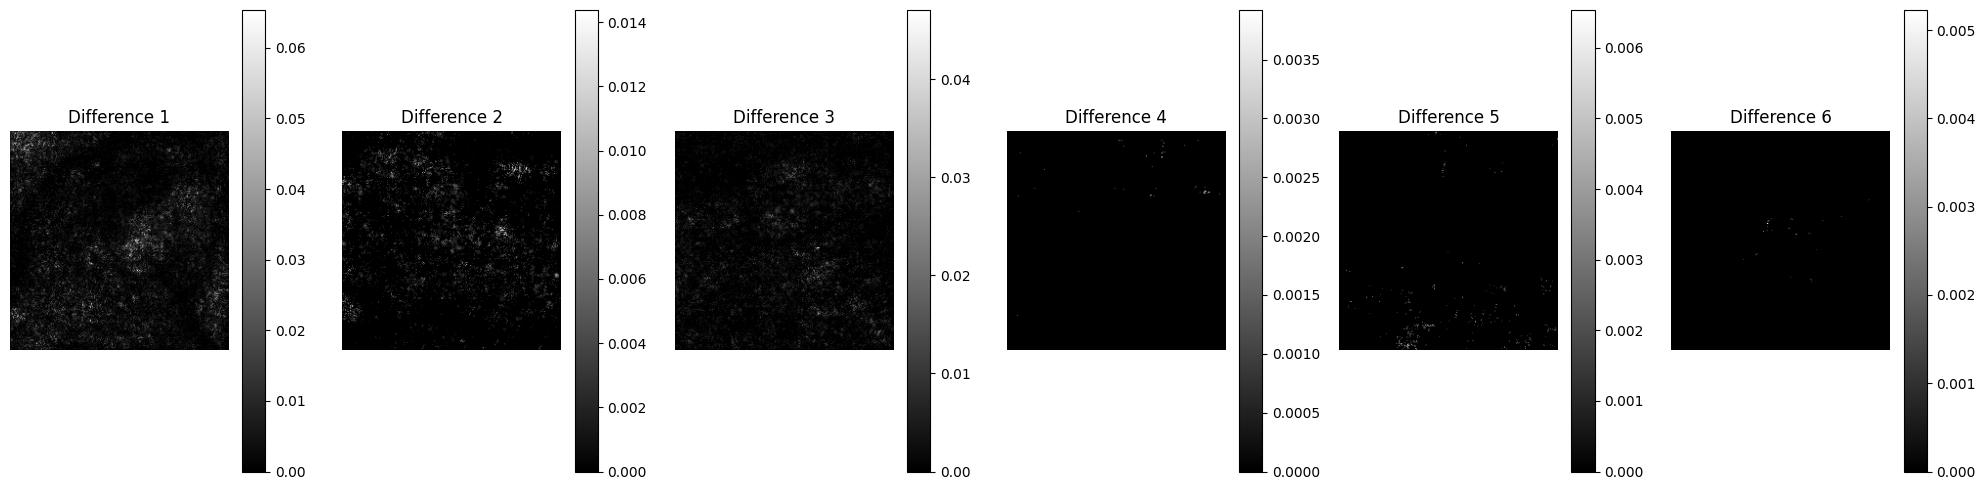

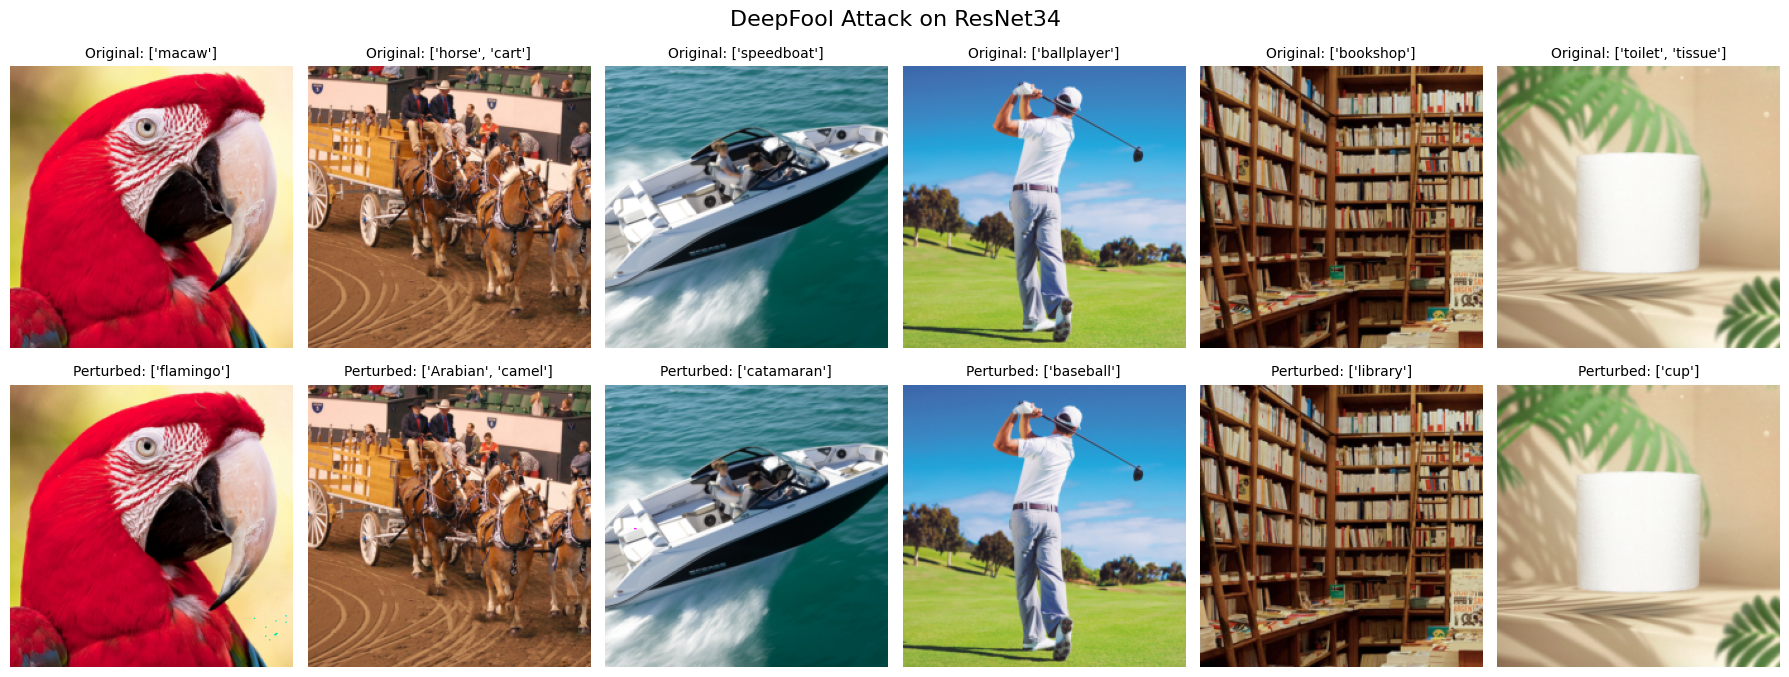

In [4]:
deepfool_args = {
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
}

(
    original_images,
    original_labels,
    original_images_norm,
    perturbed_images,
    perturbed_labels,
    perturbed_images_norm,
) = make_examples(deepfool, deepfool_args)

plot_diff(original_images_norm, perturbed_images_norm)

plot_comparaison(original_images, perturbed_images, original_labels, perturbed_labels)

## Perturbing a region of the image using Local DEEPFOOL

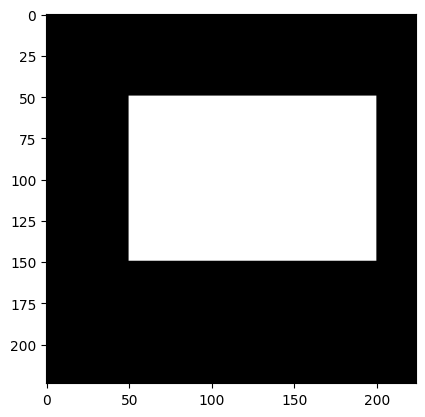

In [5]:
region_mask = np.zeros((224, 224), dtype=np.int32)
region_mask[50:150, 50:200] = 1

plt.imshow((region_mask))
plt.imshow(region_mask, cmap="gray")
plt.show()

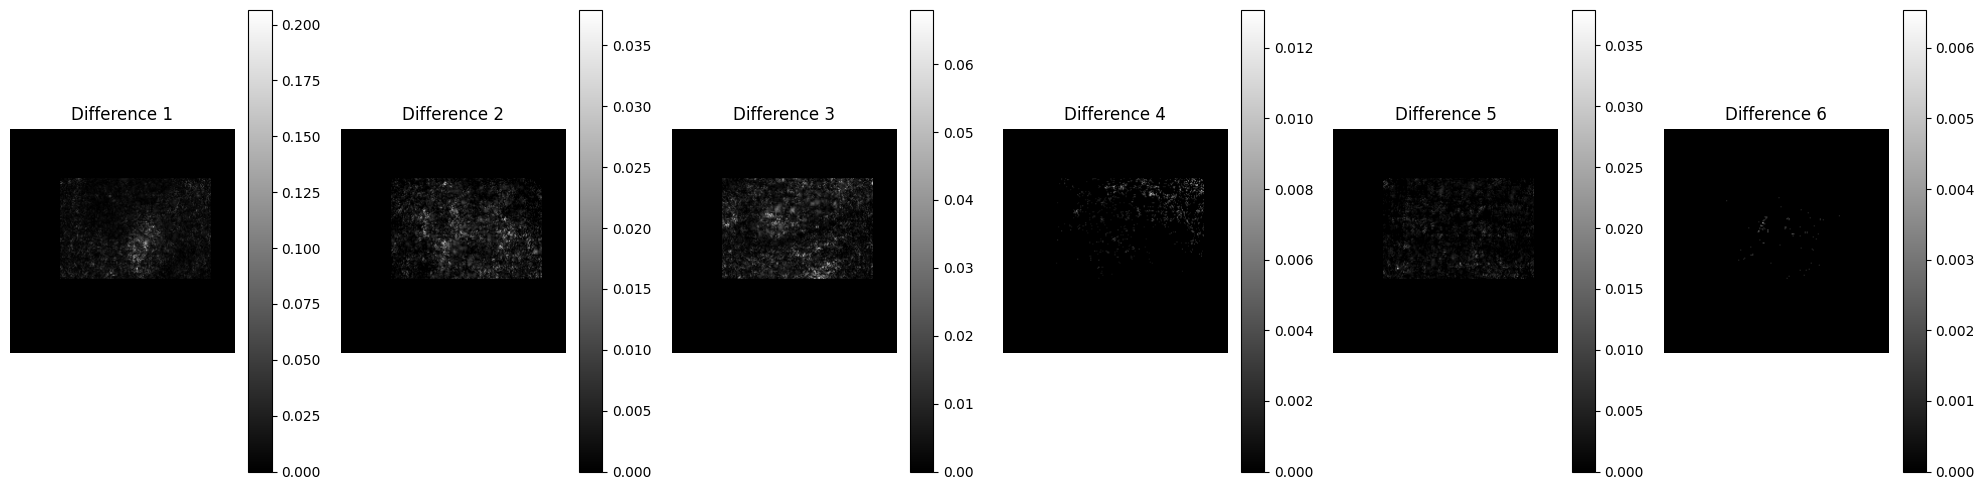

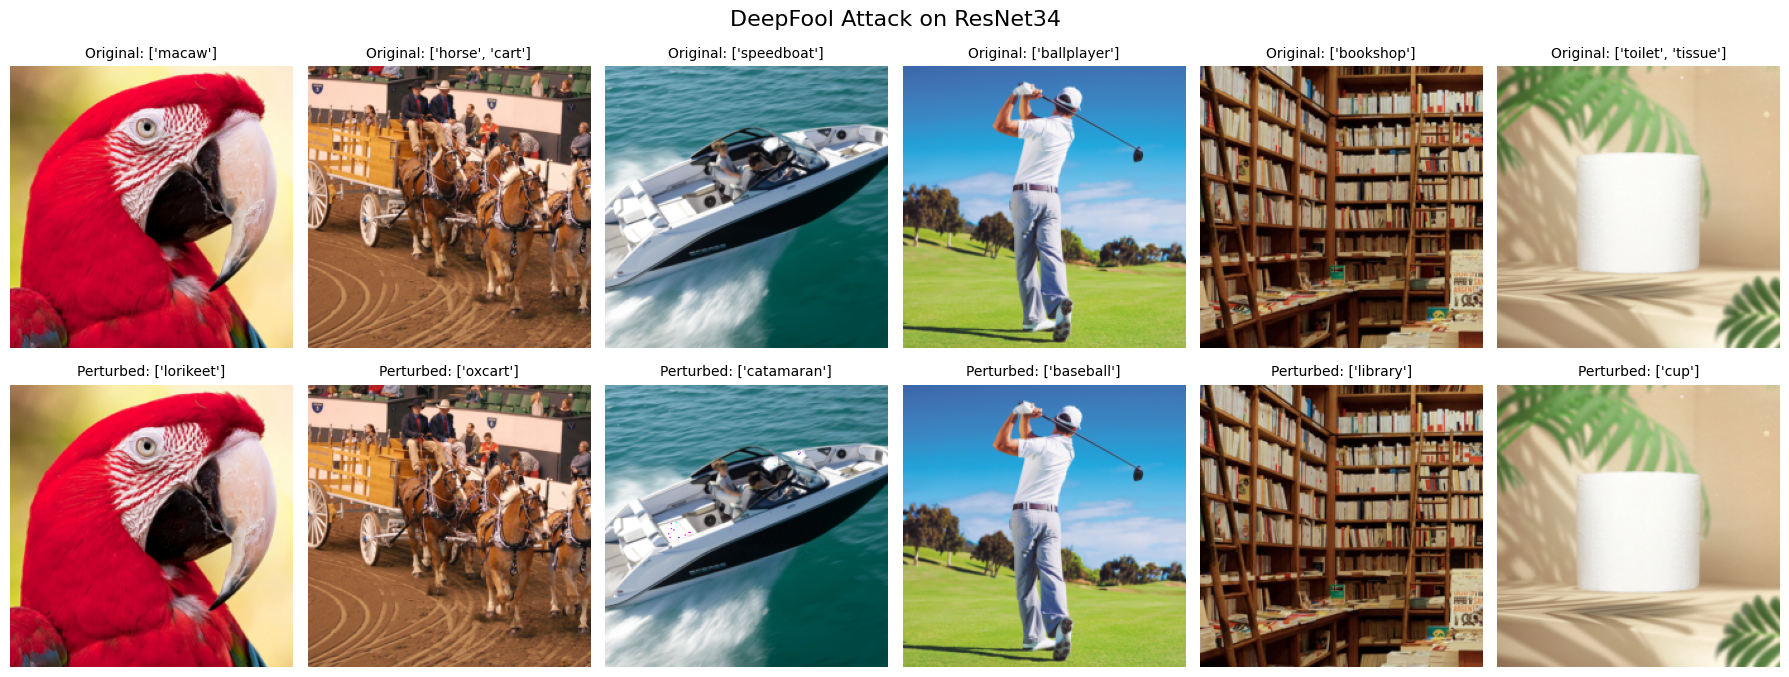

In [6]:
local_deepfool_args = {
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    "region_mask": region_mask,  # Region mask for the image
    "verbose": False,  # Verbosity flag
}

(
    original_images,
    original_labels,
    original_images_norm,
    perturbed_images,
    perturbed_labels,
    perturbed_images_norm,
) = make_examples(local_deepfool, local_deepfool_args)

plot_diff(original_images_norm, perturbed_images_norm)

plot_comparaison(original_images, perturbed_images, original_labels, perturbed_labels)

## Perturbing a local region of an image to a target Class

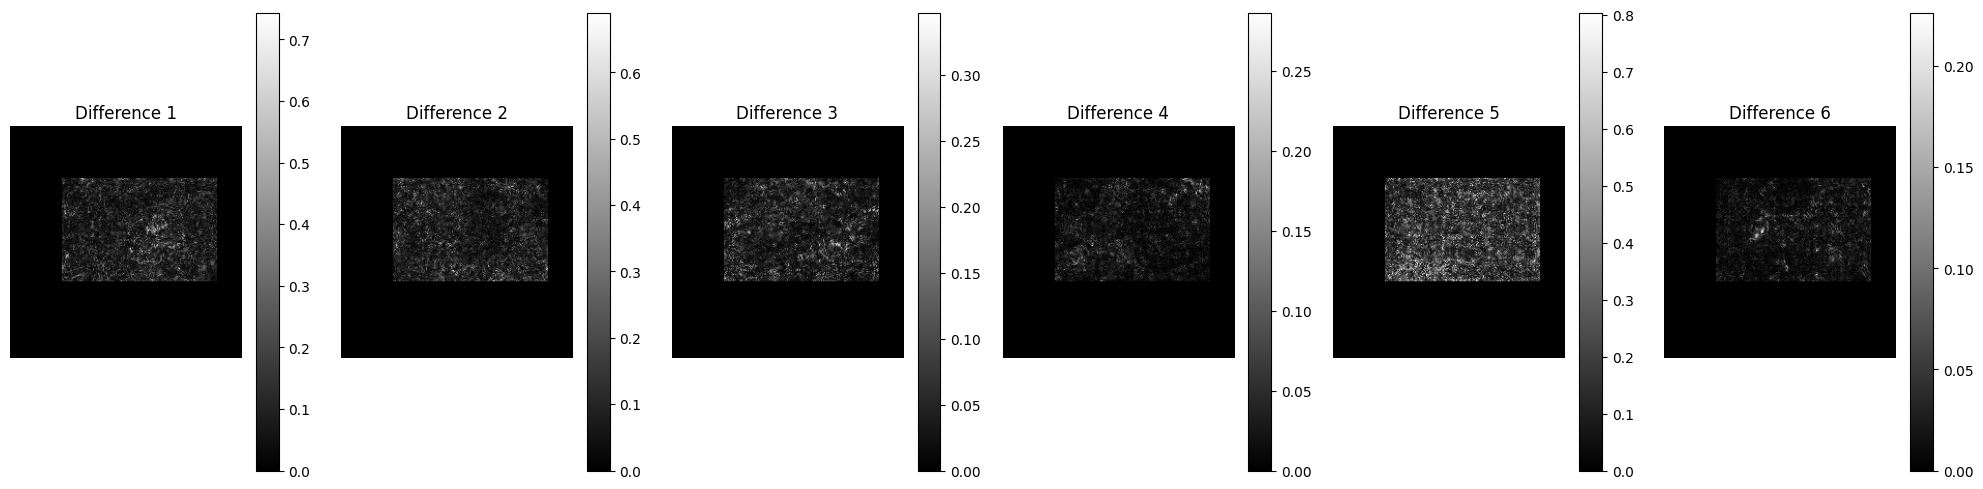

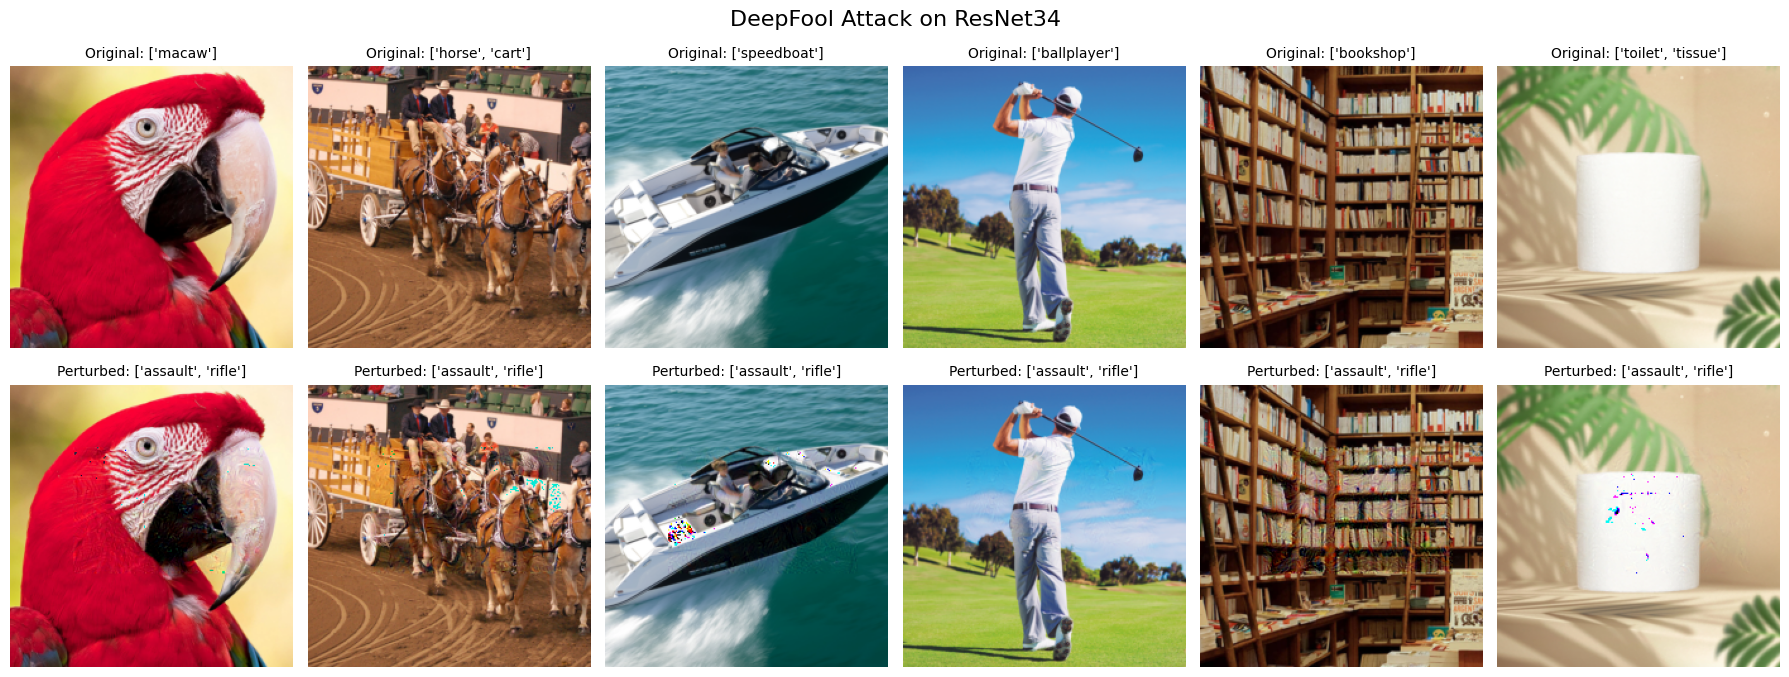

In [7]:
specific_deepfool_args = {
    "specific_label": TARGET_CLASS,  # Assault rifle class
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    "region_mask": region_mask,  # Region mask for the image
}

(
    original_images,
    original_labels,
    original_images_norm,
    perturbed_images,
    perturbed_labels,
    perturbed_images_norm,
) = make_examples(deepfool_specific, specific_deepfool_args)

plot_diff(original_images_norm, perturbed_images_norm)

plot_comparaison(original_images, perturbed_images, original_labels, perturbed_labels)

# SAM application

In [8]:
import torch
from segment_anything import sam_model_registry
import cv2
from segment_anything import SamAutomaticMaskGenerator
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x["area"]), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones(
        (
            sorted_anns[0]["segmentation"].shape[0],
            sorted_anns[0]["segmentation"].shape[1],
            4,
        )
    )
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann["segmentation"]
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def diff(original_images, perturbed_images):
    # Calculate and display the difference between original and perturbed images
    difference_images = []

    for orig, pert in zip(original_images, perturbed_images):
        # Convert images to tensors
        if isinstance(orig, Image.Image):
            orig_tensor = transforms.ToTensor()(orig)
        else:
            orig_tensor = orig
        if isinstance(pert, Image.Image):
            pert_tensor = transforms.ToTensor()(pert)
        else:
            pert_tensor = pert

        # Calculate the difference
        diff_tensor = torch.abs(orig_tensor - pert_tensor)

        # Convert the difference tensor back to a PIL image
        diff_image = transforms.ToPILImage()(diff_tensor)
        difference_images.append(diff_image)

    return difference_images


def plot_diff_sam(original_images, perturbed_images, region_masks=None):
    assert (
        len(original_images) == len(perturbed_images)
    ), f"Number of original ({len(original_images)}) and perturbed ({len(perturbed_images)}) images must be the same"

    difference_images = diff(original_images, perturbed_images)

    # Display the difference images with colorbars
    fig_diff, ax_diff = plt.subplots(2, 6, figsize=(20, 5))
    for col in range(6):
        ax_diff[0][col].imshow(transforms.ToPILImage()(region_masks[col]), cmap="gray")
        ax_diff[0][col].set_title(f"Region {col+1}")
        ax_diff[0][col].axis("off")

    for col in range(6):
        # Convert the difference tensor to grayscale for visualization
        diff_im = transforms.ToTensor()(difference_images[col])
        diff_gray = torch.mean(
            diff_im, dim=0
        )  # Convert to grayscale by averaging channels
        im = ax_diff[1][col].imshow(diff_gray, cmap="gray")
        ax_diff[1][col].set_title(f"Difference {col+1}")
        ax_diff[1][col].axis("off")
        fig_diff.colorbar(im, ax=ax_diff[1][col], orientation="vertical")

    fig_diff.suptitle("Difference between Original and Perturbed Images")
    plt.tight_layout()
    plt.show()


def plot_comparaison(
    original_images, perturbed_images, original_labels, perturbed_labels
):
    assert (
        len(original_images)
        == len(perturbed_images)
        == len(original_labels)
        == len(perturbed_labels)
    ), f"Lengths are not equal: original_images={len(original_images)}, perturbed_images={len(perturbed_images)}, original_labels={len(original_labels)}, perturbed_labels={len(perturbed_labels)}"

    fig, ax = plt.subplots(2, 6, figsize=(18, 7))
    for col in range(6):
        ax[0][col].imshow(transforms.ToPILImage()(original_images[col]))
        ax[0][col].set_title(f"Original: {original_labels[col]}", fontsize=10)
        ax[0][col].axis("off")

    for col in range(6):
        ax[1][col].imshow(transforms.ToPILImage()(perturbed_images[col]))
        ax[1][col].set_title(f"Perturbed: {perturbed_labels[col]}", fontsize=10)
        ax[1][col].axis("off")

    fig.suptitle("DeepFool Attack on ResNet34", fontsize=16)
    plt.subplots_adjust(top=0.85, hspace=0.3)
    plt.show()


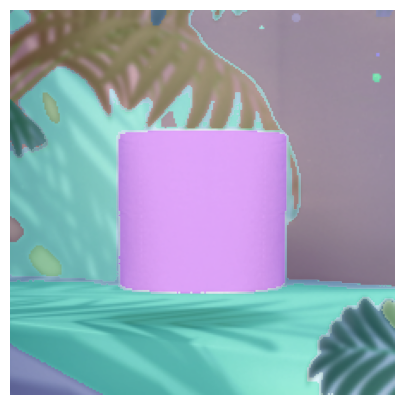

In [10]:
im_orig = Image.open(f"data/demo_deepfool/test_img6.jpg")

tf = transforms.Compose(
    [
        transforms.Resize(256),  # Updated from transforms.Scale
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

CHECKPOINT_PATH = (
    "sam_vit_h_4b8939.pth"  # Replace with the path to the SAM checkpoint file
)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam, output_mode="binary_mask")

# convert orginal_images[0] to numpy
image_rgb = cv2.cvtColor(np.array(tf(im_orig).permute(1, 2, 0)), cv2.COLOR_BGR2RGB)
result = mask_generator.generate(image_rgb) 

# print(result)
plt.figure(figsize=(5, 5))
plt.imshow(image_rgb)
show_anns(result)
plt.axis("off")
plt.show()

In [11]:
def make_examples_sam(im_path, func, xargs):
    # Load pretrained ResNet-34 model
    net = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

    # Switch to evaluation mode
    net.eval()

    original_images = []
    original_labels = []
    original_images_norm = []
    perturbed_images = []
    perturbed_labels = []
    perturbed_images_norm = []
    region_masks = []

    im_orig = Image.open(im_path)

    # Mean and std used for normalization (ImageNet stats)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    original_image = transforms.Compose(
        [
            transforms.Resize(256),  # Updated from transforms.Scale
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    )(im_orig)

    original_image_norm = transforms.Compose(
        [
            transforms.Resize(256),  # Updated from transforms.Scale
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    )(im_orig)

    # Preprocessing the image: resize, crop, convert to tensor, and normalize
    im = transforms.Compose(
        [
            transforms.Resize(256),  # Updated from transforms.Scale
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    )(im_orig).cpu()  # Ensure the tensor is on the CPU

    CHECKPOINT_PATH = (
        "sam_vit_h_4b8939.pth"  # Replace with the path to the SAM checkpoint file
    )

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    MODEL_TYPE = "vit_h"

    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
    sam.to(device=DEVICE)

    mask_generator = SamAutomaticMaskGenerator(sam, output_mode="binary_mask")

    # convert orginal_images[0] to numpy
    image_rgb = cv2.cvtColor(
        np.array(original_image.permute(1, 2, 0)), cv2.COLOR_BGR2RGB
    )
    result = mask_generator.generate(image_rgb)

    sorted_anns = sorted(result, key=(lambda x: x["area"]), reverse=True)

    for i in range(7):
        original_images.append(original_image)
        original_images_norm.append(original_image_norm)

        mask = sorted_anns[i]["segmentation"]
        region_mask = mask.astype(np.uint8)
        region_masks.append(region_mask)

        # Run the provided function (e.g., DeepFool attack)
        r, loop_i, label_orig, label_pert, pert_image = func(
            im, net, **xargs, region_mask=region_mask
        )

        # Load class labels from file
        labels = (
            open(os.path.join("data/demo_deepfool/synset_words.txt"), "r")
            .read()
            .split("\n")
        )

        # Get original and perturbed class labels
        str_label_orig = labels[int(label_orig)].split(",")[0]  # Changed np.int to int
        str_label_pert = labels[int(label_pert)].split(",")[0]

        original_labels.append(str_label_orig.split()[1:])
        perturbed_labels.append(str_label_pert.split()[1:])

        # Function to clip tensor values between minv and maxv
        def clip_tensor(A, minv, maxv):
            A = torch.clamp(A, minv, maxv)  # Use torch.clamp for cleaner implementation
            return A

        # Clipping function for images (0-255 range)
        clip = lambda x: clip_tensor(x, 0, 255)

        # Inverse transformation to convert perturbed image back to PIL format
        tf = transforms.Compose(
            [
                transforms.Normalize(
                    mean=[0, 0, 0], std=[1 / s for s in std]
                ),  # Reverse normalization
                transforms.Normalize(
                    mean=[-m for m in mean], std=[1, 1, 1]
                ),  # Subtract mean
                transforms.Lambda(clip),  # Clip the values to ensure valid image range
                transforms.ToPILImage(),  # Convert tensor back to PIL image
                transforms.CenterCrop(224),  # Center crop to 224x224
                transforms.ToTensor(),  # Convert back to tensor
            ]
        )

        pert_image = pert_image.view(pert_image.size()[-3:]).type(torch.FloatTensor)
        perturbed_images.append(tf(pert_image))
        perturbed_images_norm.append(pert_image)
    return (
        original_images,
        original_labels,
        original_images_norm,
        perturbed_images,
        perturbed_labels,
        perturbed_images_norm,
        region_masks,
    )

## Perturbing a region of an image using SAM and local_deepfool

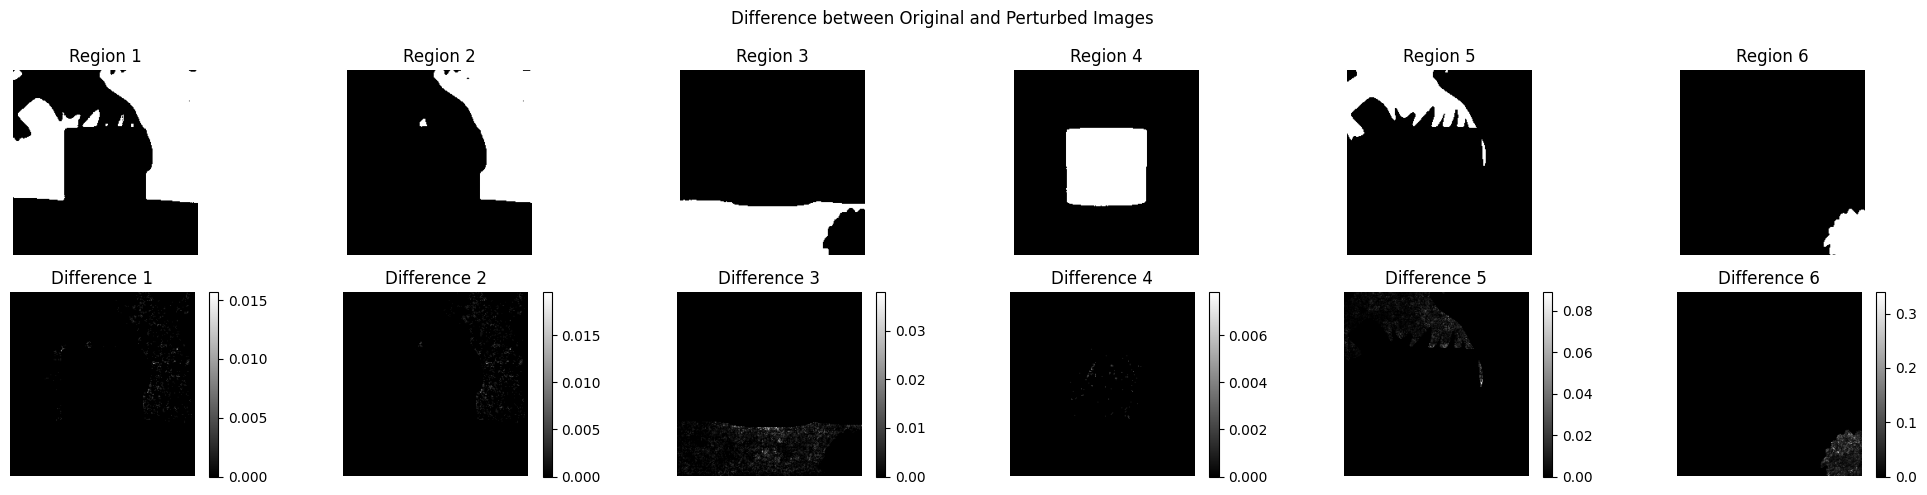

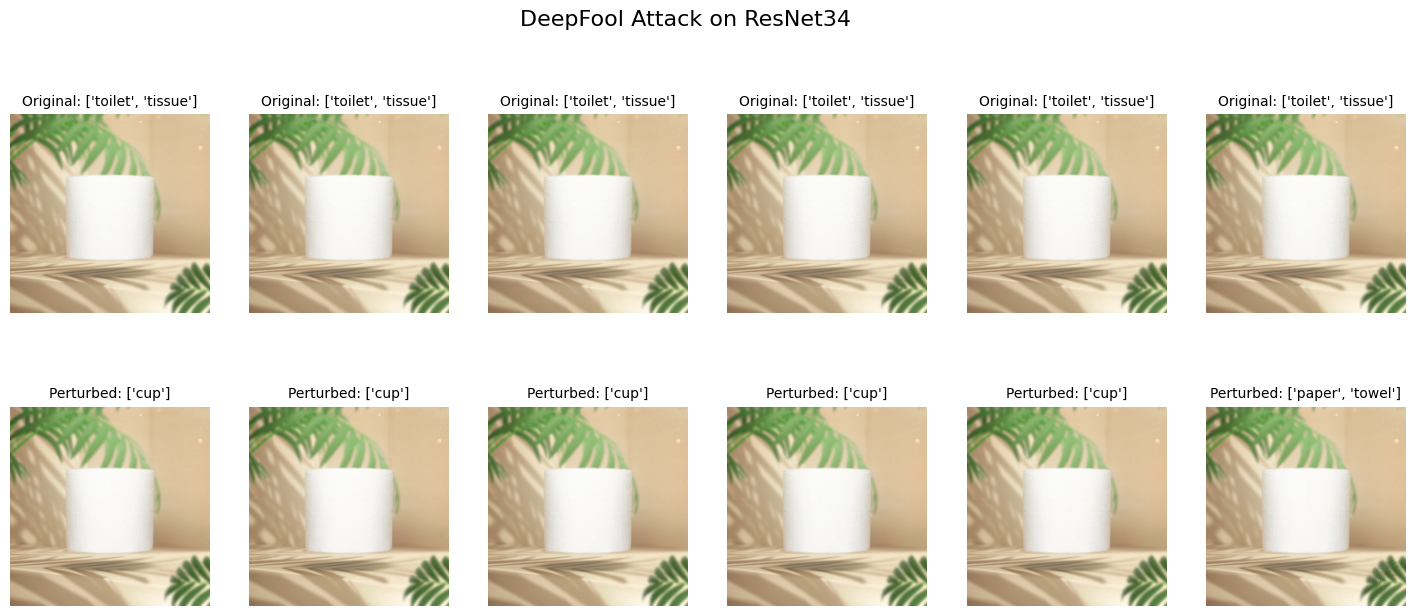

In [12]:
sam_deepfool_args = {
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    # region mask is done inside make_examples_sam
}

(
    original_images,
    original_labels,
    original_images_norm,
    perturbed_images,
    perturbed_labels,
    perturbed_images_norm,
    region_masks,
) = make_examples_sam(
    "data/demo_deepfool/test_img6.jpg", local_deepfool, sam_deepfool_args
)

plot_diff_sam(original_images_norm, perturbed_images_norm, region_masks)

plot_comparaison(original_images, perturbed_images, original_labels, perturbed_labels)


## Perturbing images into a target class using SAM and region perturbation

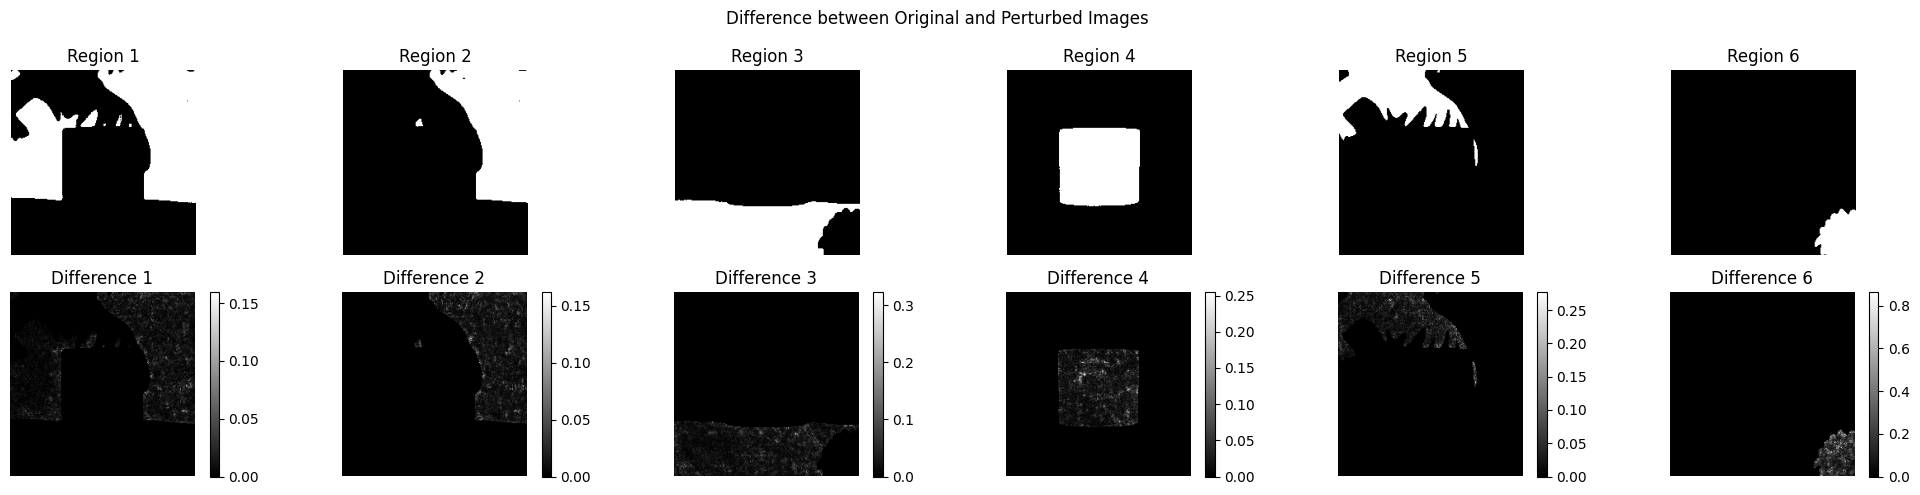

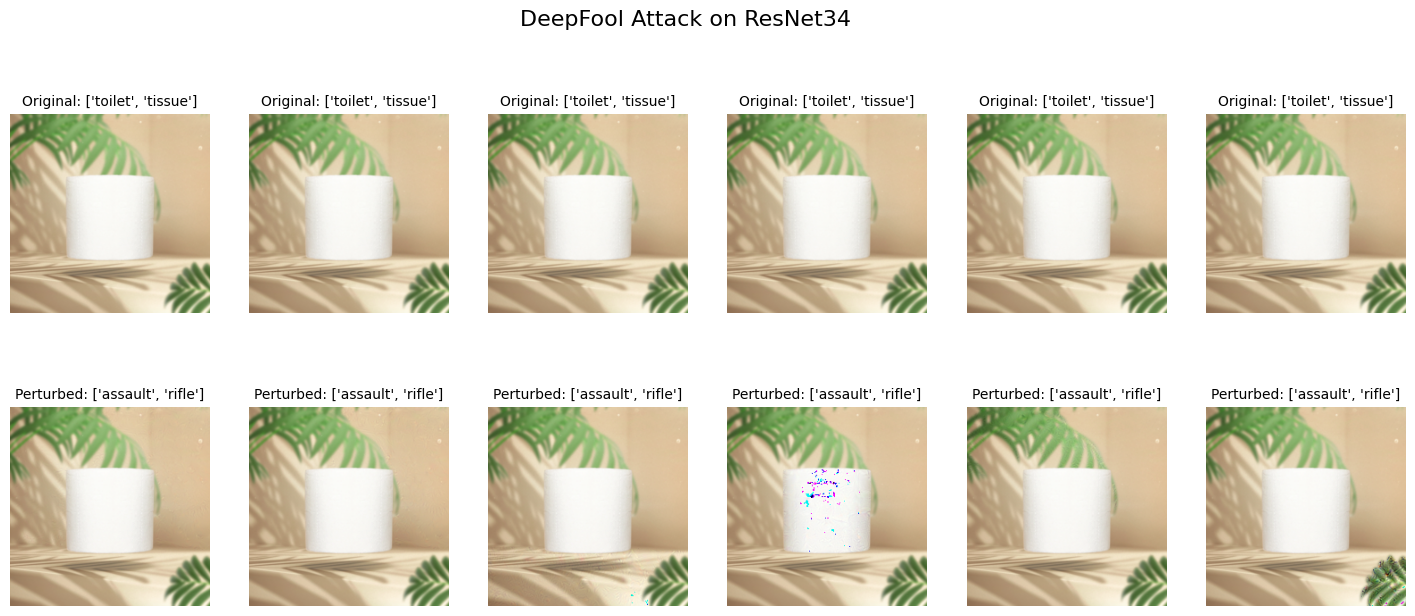

In [13]:
sam_deepfool_args = {
    "specific_label": TARGET_CLASS,  # Assault rifle class
    "num_classes": NUM_CLASSES,  # Number of classes
    "overshoot": OVERSHOOT,  # Maximum perturbation allowed
    "max_iter": MAX_ITER,  # Maximum number of iterations
    # region mask is done inside make_examples_sam
}

(
    original_images,
    original_labels,
    original_images_norm,
    perturbed_images,
    perturbed_labels,
    perturbed_images_norm,
    region_masks,
) = make_examples_sam(
    "data/demo_deepfool/test_img6.jpg", deepfool_specific, sam_deepfool_args
)

plot_diff_sam(original_images_norm, perturbed_images_norm, region_masks)

plot_comparaison(original_images, perturbed_images, original_labels, perturbed_labels)